In [0]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

import os
import numpy as np
import matplotlib.pyplot as plt
import patoolib

In [4]:
patoolib.extract_archive("cat_dog_small.rar",outdir=".")

patool: Extracting cat_dog_small.rar ...
patool: running /usr/bin/unrar x -- /content/cat_dog_small.rar
patool:     with cwd='.'
patool: ... cat_dog_small.rar extracted to `.'.


'.'

In [6]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step


<h2 class="bold"  align="center" color="red"> <font color='red' face="verdana">Fast feature extraction without data augmentation</font></h2>


In [0]:
datagen = ImageDataGenerator(rescale=1./255)
base_dir = "cat_dog_small"
train_dir = os.path.join(base_dir,"train")
validation_dir=os.path.join(base_dir,"validation")
test_dir = os.path.join(base_dir,"test")

In [0]:
def extract_features(directory,sample_count):
  extracted_features = np.zeros((sample_count,4,4,512))
  extracted_labels = np.zeros(sample_count)
  generator = datagen.flow_from_directory(directory,target_size=(150,150),class_mode="binary",batch_size=20)
  i = 0
  batch_size = 20
  for data_batch, label_batch in generator:
    features_batch = conv_base.predict(data_batch)
    extracted_features[i*batch_size:(i+1)*batch_size] = features_batch
    extracted_labels[i*batch_size:(i+1)*batch_size] = label_batch
    i+=1
    if i*batch_size >= sample_count:
      break
    return extracted_features, extracted_labels

In [18]:
train_features, train_labels = extract_features(train_dir,2000)
validation_features, validation_labels = extract_features(validation_dir,1000)
test_features, test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = train_features.reshape((2000,4*4*512))
validation_features = validation_features.reshape((1000,(4*4*512)))
test_features = test_features.reshape((1000,(4*4*512)))

In [0]:
model = Sequential()
model.add(Dense(256,activation="relu",input_dim=4*4*512))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

In [0]:
model.compile(loss="binary_crossentropy",optimizer=RMSprop(lr=2e-5),metrics=["acc"])

In [27]:
history = model.fit(train_features,train_labels,batch_size=20,validation_data=(validation_features,validation_labels),
                   epochs=30)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 446us/step - loss: 0.6913 - acc: 0.9960 - val_loss: 0.6890 - val_acc: 0.9920
Epoch 2/30
2000/2000 [==============================] - 1s 296us/step - loss: 0.6845 - acc: 0.9950 - val_loss: 0.6821 - val_acc: 0.9910
Epoch 3/30
2000/2000 [==============================] - 1s 270us/step - loss: 0.6752 - acc: 0.9980 - val_loss: 0.6752 - val_acc: 0.9900
Epoch 4/30
2000/2000 [==============================] - 1s 268us/step - loss: 0.6683 - acc: 0.9970 - val_loss: 0.6671 - val_acc: 0.9910
Epoch 5/30
2000/2000 [==============================] - 1s 258us/step - loss: 0.6595 - acc: 0.9980 - val_loss: 0.6582 - val_acc: 0.9910
Epoch 6/30
2000/2000 [==============================] - 1s 263us/step - loss: 0.6490 - acc: 0.9985 - val_loss: 0.6515 - val_acc: 0.9910
Epoch 7/30
2000/2000 [==============================] - 1s 256us/step - loss: 0.6406 - acc: 0.9990 - val_loss: 0.6403 - val_acc: 0.9920


Text(0.5, 1.0, 'Training and Validation loss')

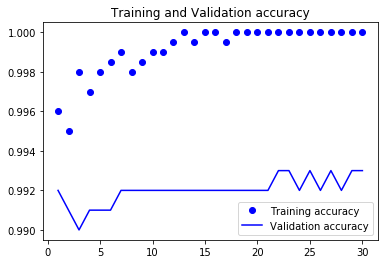

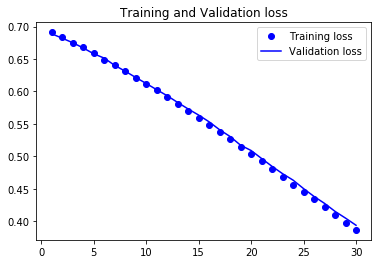

In [28]:
%matplotlib inline
hist = history.history
acc, loss = hist['acc'], hist['loss']
val_acc, val_loss = hist["val_acc"], hist['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,"bo",label="Training accuracy")
plt.plot(epochs,val_acc,"b",label="Validation accuracy")
plt.legend()
plt.title("Training and Validation accuracy")
plt.figure()
plt.plot(epochs,loss,"bo",label="Training loss")
plt.plot(epochs,val_loss,"b",label="Validation loss")
plt.legend()
plt.title("Training and Validation loss")

<h2 class="bold"  align="center" color="red"> <font color='red' face="verdana">Feature extraction with data augmentation</font></h2>


In [0]:
network = Sequential()
network.add(conv_base)
network.add(Flatten())
network.add(Dense(256,activation="relu"))
#network.add(Dropout(0.3))
network.add(Dense(1,activation="sigmoid"))

In [43]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
conv_base.trainable = False

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,
                                   rotation_range=40,shear_range=0.2,horizontal_flip=True,fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

In [46]:
train_generator = train_datagen.flow_from_directory(train_dir,batch_size=20,target_size=(150,150),class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,target_size=(150,150),batch_size=20,class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
network.compile(loss="binary_crossentropy",optimizer=RMSprop(lr=2e-5),metrics=["acc"])

In [48]:
history_1 = network.fit_generator(train_generator,epochs=30,steps_per_epoch=100,validation_data=validation_generator,
                               validation_steps=50)

Epoch 1/30
 22/100 [=====>........................] - ETA: 15s - loss: 0.6656 - acc: 0.5955

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expect

 99/100 [============================>.] - ETA: 0s - loss: 0.5897 - acc: 0.6899

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

100/100 [==============================] - 20s 199ms/step - loss: 0.5882 - acc: 0.6925 - val_loss: 0.4411 - val_acc: 0.8260
Epoch 2/30
100/100 [==============================] - 18s 177ms/step - loss: 0.4786 - acc: 0.7965 - val_loss: 0.3518 - val_acc: 0.8700
Epoch 3/30
100/100 [==============================] - 17s 175ms/step - loss: 0.4251 - acc: 0.8125 - val_loss: 0.3210 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 18s 179ms/step - loss: 0.3932 - acc: 0.8295 - val_loss: 0.3075 - val_acc: 0.8750
Epoch 5/30
100/100 [==============================] - 19s 188ms/step - loss: 0.3867 - acc: 0.8270 - val_loss: 0.2803 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 18s 176ms/step - loss: 0.3585 - acc: 0.8465 - val_loss: 0.2922 - val_acc: 0.8710
Epoch 7/30
100/100 [==============================] - 18s 177ms/step - loss: 0.3634 - acc: 0.8375 - val_loss: 0.2837 - val_acc: 0.8800
Epoch 8/30
100/100 [==============================] - 18s 176ms/st

In [41]:
#len(conv_base.trainable_weights)

0